In [97]:
import numpy as np
import skimage as sk
import skimage.io as skio
import matplotlib.pyplot as plt

# name of the input file
imname = 'data/emir.tif'

# read in the image
im = skio.imread(imname)

# convert to double (might want to do this later on to save memory)    
im = sk.img_as_float(im)
    
# compute the height of each part (just 1/3 of total)
height = np.floor(im.shape[0] / 3.0).astype(int)
b = im[:height]
g = im[height: 2*height]
r = im[2*height: 3*height]

import sys
np.set_printoptions(threshold=sys.maxsize)

In [98]:
def preprocess(im, w_tol=0.95):
    col_means = im.mean(axis=0)
    cols = np.where(col_means < w_tol)[0]
    left = cols.min()+10 if cols.any() and cols.min() < im.shape[1] * 0.1 else 0
    right = cols.max()-10 if cols.any() and cols.max() > im.shape[1] * 0.9 else im.shape[1]-1
    im = im[:, left:right]

    height = np.floor(im.shape[0] / 3.0).astype(int)
    b = im[:height]
    g = im[height: 2*height]
    r = im[2*height: 3*height]
    
    return r, g, b

def postprocess(im, tol=0.5, mag_min=0.2, mag_max=0.8):
    diff_rg = np.abs(im[:,:,0] - im[:,:,1])
    diff_rb = np.abs(im[:,:,0] - im[:,:,2])
    diff_gb = np.abs(im[:,:,1] - im[:,:,2])
    diff = diff_rg**2 + diff_rb**2 + diff_gb**2

    mag = im.mean(axis=2)
    diff = np.maximum(diff, (mag_min > mag) | (mag > mag_max))
    row_agree = diff.mean(axis=1)
    col_agree = diff.mean(axis=0)

    good_rows = np.where(row_agree < tol)[0]
    good_cols = np.where(col_agree < tol)[0]
    top, bottom = good_rows[0] if good_rows.any() else 0, good_rows[-1] if good_rows.any() else im.shape[0]-1
    left, right = good_cols[0] if good_cols.any() else 0, good_cols[-1] if good_cols.any() else im.shape[1]-1
    # Use percentage-based clipping instead of fixed margin
    clip_percent = 0.1
    row_margin = int(im.shape[0] * clip_percent)
    col_margin = int(im.shape[1] * clip_percent)
    top = min(top, row_margin)
    bottom = max(bottom, im.shape[0] - row_margin - 1)
    left = min(left, col_margin)
    right = max(right, im.shape[1] - col_margin - 1)
    cropped = im[top:bottom+1, left:right+1, :]
    return cropped

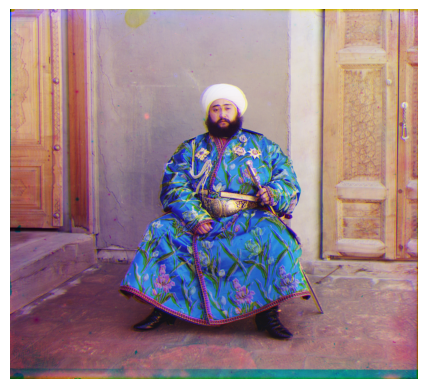

In [99]:
from numpy.lib.stride_tricks import sliding_window_view

def gaussian_reduce(im):
    kernel = np.array([[1, 2, 1], 
                       [2, 4, 2], 
                       [1, 2, 1]], dtype=np.float32) / 16.0
    windows = sliding_window_view(im, kernel.shape)
    blurred = (windows * kernel).sum(axis=(-2, -1))
    return blurred[::2, ::2]

def align_one(base, im, search):
    best_dy = 0
    best_dx = 0
    min_error = float('inf')
    
    for dy in range(-search, search + 1):
        for dx in range(-search, search + 1):
            shifted_im = np.roll(np.roll(im, dy, axis=0), dx, axis=1)
            
            # Compute NCC only on the central 90% region (ignore outside 5%)
            h, w = base.shape
            y0, y1 = int(h * 0.05), int(h * 0.9)
            x0, x1 = int(w * 0.05), int(w * 0.9)
            region_base = base[y0:y1, x0:x1]
            region_shifted = shifted_im[y0:y1, x0:x1]
            norm_base = region_base / np.linalg.norm(region_base)
            norm_shifted = region_shifted / np.linalg.norm(region_shifted)
            error = -np.sum(norm_base * norm_shifted)
            
            if error < min_error:
                min_error = error
                best_dy = dy
                best_dx = dx
                
    return best_dx, best_dy

def align_pyramid(base, im, n=3):
    if n == 0:
        return align_one(base, im, search=10)
    reduced_base = gaussian_reduce(base)
    reduced_im = gaussian_reduce(im)
    dx, dy = align_pyramid(reduced_base, reduced_im, n - 1)
    dx *= 2
    dy *= 2
    shifted_im = np.roll(np.roll(im, dy, axis=0), dx, axis=1)
    dx2, dy2 = align_one(base, shifted_im, search=2)
    return dx + dx2, dy + dy2

def align_big(im):
    r, g, b = preprocess(im)
    dx_g, dy_g = align_pyramid(r, g, n=4)
    dx_b, dy_b = align_pyramid(r, b, n=4)
    aligned_g = np.roll(np.roll(g, dy_g, axis=0), dx_g, axis=1)
    aligned_b = np.roll(np.roll(b, dy_b, axis=0), dx_b, axis=1)
    aligned_im = np.dstack([r, aligned_g, aligned_b])
    return postprocess(aligned_im), (dx_g, dy_g), (dx_b, dy_b)

def align_small(im):
    r, g, b = preprocess(im)
    dx_g, dy_g = align_one(r, g, 15)
    dx_b, dy_b = align_one(r, b, 15)
    aligned_g = np.roll(np.roll(g, dy_g, axis=0), dx_g, axis=1)
    aligned_b = np.roll(np.roll(b, dy_b, axis=0), dx_b, axis=1)
    aligned_im = np.dstack([r, aligned_g, aligned_b])
    return postprocess(aligned_im), (dx_g, dy_g), (dx_b, dy_b)

plt.imshow(align_big(im)[0])
plt.axis('off')
plt.show()

In [100]:
import os

input_dir = 'data'
output_dir = 'out'
os.makedirs(output_dir, exist_ok=True)

for fname in os.listdir(input_dir):
    fpath = os.path.join(input_dir, fname)
    if fname != "tobolsk.jpg":
        continue
    img = skio.imread(fpath)
    img = sk.img_as_float(img)
    if img.shape[0] > 1500 or img.shape[1] > 1500:
        aligned, (dx_g, dy_g), (dx_b, dy_b) = align_big(img)
    else:
        aligned, (dx_g, dy_g), (dx_b, dy_b) = align_small(img)
    outname = os.path.splitext(fname)[0] + '.jpg'
    outpath = os.path.join(output_dir, outname)
    skio.imsave(outpath, (aligned * 255).astype(np.uint8))
    print(fname, "->", outname, " (g:", dx_g, dy_g, ", b:", dx_b, dy_b, ")")

tobolsk.jpg -> tobolsk.jpg  (g: -1 -4 , b: -3 -6 )
